In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import tensornets as nets
import skimage.transform
from sklearn.metrics import confusion_matrix
import h5py

## List of tasks:

1. Load images as arrays
2. Load labels
3. Convert labels from one-hot vector to vector of labels
4. Display images with labels
5. Flip images and labels
6. Make x and y training + dev arrays
7. Load pre-trained architecture (eg. VGG19)
8. Train with new data
9. Make predictions
10. Set up metrics - accuracy, precision, recall. Output train and dev metrics.
11. Tune hyperparameters

In [63]:
img_loc = '../ISIC2018_Task3_Training_Input/'
filelist = glob.glob(img_loc+'*.jpg')

In [64]:
filelist.sort()
len(filelist)

10015

In [65]:
# Load images as arrays

bs = len(filelist)

X_orig = np.empty([bs, 224, 224, 3])
for i, fname in enumerate(filelist[:bs]):
    img = plt.imread(fname)
    img = skimage.transform.resize(img, (224, 224), mode='constant')
    #img_arr = np.expand_dims(img, axis = 0)
    X_orig[i] = img


#X_orig = np.vstack(xlst)

In [66]:
X_orig.shape

(10015, 224, 224, 3)

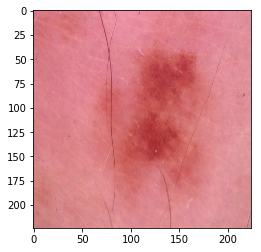

In [67]:
plt.imshow(X_orig[1])

In [68]:
# Load labels

Y_df = pd.read_csv('../ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv')

In [69]:
Y_df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
Y_orig = np.array(Y_df.iloc[:bs, 1:])

In [71]:
Y_orig.shape

(10015, 7)

In [72]:
labels = Y_df.iloc[:,1:].idxmax(axis = 1)

In [73]:
labels.head()

0     NV
1     NV
2     NV
3     NV
4    MEL
dtype: object

Replace the labels with the following names of diseases:

* MEL: “Melanoma” diagnosis confidence
* NV: “Melanocytic nevus” diagnosis confidence
* BCC: “Basal cell carcinoma” diagnosis confidence
* AKIEC: “Actinic keratosis / Bowen’s disease (intraepithelial carcinoma)” diagnosis confidence
* BKL: “Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)” diagnosis confidence
* DF: “Dermatofibroma” diagnosis confidence
* VASC: “Vascular lesion” diagnosis confidence

In [74]:
labels.replace('MEL','Melanoma',inplace=True)
labels.replace('NV','Melanocytic nevus',inplace=True)
labels.replace('BCC','Basal cell carcinoma',inplace=True)
labels.replace('AKIEC','Actinic keratosis',inplace=True)
labels.replace('BKL','Benign keratosis',inplace=True)
labels.replace('DF','Dermatofibroma',inplace=True)
labels.replace('VASC','Vascular lesion',inplace=True)

ISIC_0024313


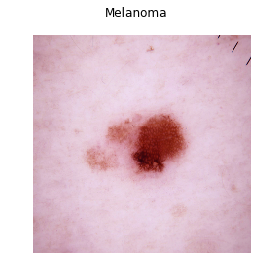

ISIC_0024314


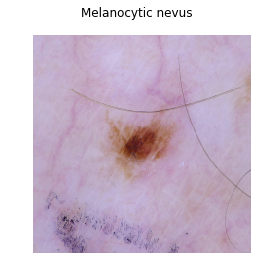

ISIC_0024315


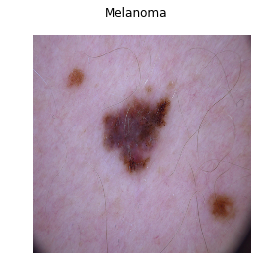

ISIC_0024316


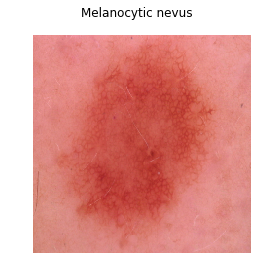

ISIC_0024317


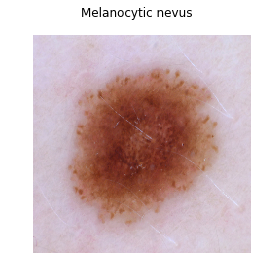

In [75]:
# Display images with labels

disp_num = 5
start_pos = 7

for i in range(start_pos,start_pos+disp_num):
    print(Y_df.iloc[i,0])
    plt.imshow(X_orig[i])
    plt.suptitle(labels[i])
    plt.axis('off')
    plt.show()


In [76]:
# Flip images and labels

m, n_H0, n_W0, n_C0 = X_orig.shape

In [77]:
X_flip = X_orig[:,:,n_W0-1::-1,:]
Y_flip = Y_orig

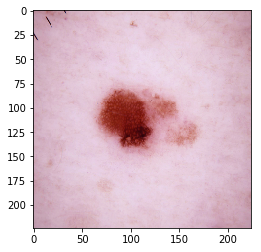

In [78]:
plt.imshow(X_flip[start_pos])

In [79]:
Y_flip.shape

(10015, 7)

In [80]:
X = np.vstack([X_orig, X_flip])
Y = np.vstack([Y_orig, Y_flip])

In [81]:
X.shape

(20030, 224, 224, 3)

In [82]:
Y.shape

(20030, 7)

In [83]:
# Make x and y training + dev arrays

train_size = 0.9

In [84]:
seed = 3
np.random.seed(seed)

In [85]:
train_index = np.random.choice(2*m, size = int(train_size*2*m), replace = False)
dev_index = list(set(range(2*m)) - set(train_index))

In [86]:
m_train = train_index.shape[0]

In [87]:
X_train = X[train_index]
Y_train = Y[train_index]

#X_train = np.empty([m_train, 224, 224, 3])
#Y_train = np.empty([m_train, 224, 224, 3])

#for i, j in enumerate(train_index):
#    X_train[i] = X[j]
#    Y_train[i] = Y[j]
X_dev = X[dev_index]
Y_dev = Y[dev_index]

In [88]:
# ImageNet input image shape is (244, 244, 3)
inputs = tf.placeholder(tf.float32, [None, 224, 224, 3])

# Output is dependent on your situation (10 for CIFAR-10)
outputs = tf.placeholder(tf.float32, [None, 7])


# model to give the name
logits = nets.ResNet50(inputs, is_training=True, classes=7)
middles = logits.get_outputs()

Z1 = tf.contrib.layers.flatten(middles[-4])
# FULLY-CONNECTED 
Z2 = tf.contrib.layers.fully_connected(Z1, 120)
# FULLY-CONNECTED 
Y_hat = tf.contrib.layers.fully_connected(Z2, 7, activation_fn = tf.nn.softmax)

In [89]:
learning_rate=1e-5
class_weights = tf.constant(np.array(np.mean(Y_df.iloc[:,1:])),dtype = 'float32')
weights = tf.reduce_sum(class_weights * outputs, axis=1)

# loss function applied to the last layer
# train on the loss (Adam Optimizer is used)

loss = tf.losses.softmax_cross_entropy(outputs, Y_hat)
weighted_loss = tf.reduce_mean(loss*weights)
train = tf.train.AdamOptimizer(learning_rate).minimize(weighted_loss)

# for measuring accuracy after forward pass

predictions = tf.argmax(Y_hat, 1)
correct_pred = tf.cast(tf.equal(predictions, tf.argmax(outputs, 1)),tf.float32)
accuracy = tf.reduce_mean(correct_pred, name='accuracy')

In [90]:
clswts = np.array(np.mean(Y_df.iloc[:,1:]))
print(clswts)
np.sum(clswts*Y_train, axis = 1)

[0.1111333  0.66949576 0.05132302 0.03265102 0.1097354  0.01148278
 0.01417873]


array([0.01417873, 0.1111333 , 0.66949576, ..., 0.1111333 , 0.66949576,
       0.66949576])

In [93]:
batch_size = 32
num_epochs = 3
train_acc = 0
m_train = X_train.shape[0]
num_batches = (m_train//batch_size) + 1

In [94]:
num_correct_preds = 0
losses = []
Y_train_preds = np.empty(shape = m_train)

m_dev = X_dev.shape[0]
Y_dev_preds = np.empty(shape = m_dev)
num_batches_dev = (m_dev//batch_size) + 1

with tf.Session() as sess:    
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Loading the parameters
    sess.run(logits.pretrained())
    
    for i in range(num_epochs):
        batch_loss = 0
        full_batch = range(m_train)
        for batch in range(num_batches):
            try:
                batch_index = np.random.choice(full_batch, size=batch_size, replace = False)
                full_batch = np.array(list(set(full_batch) - set(batch_index)))
            except ValueError:
                batch_index = full_batch
            X_train_batch = X_train[batch_index]
            Y_train_batch = Y_train[batch_index]
            sess.run(train, feed_dict = {inputs: X_train_batch, outputs: Y_train_batch})
            temp_loss = sess.run(loss, feed_dict ={inputs: X_train_batch, outputs: Y_train_batch})
            batch_loss += temp_loss/num_batches
        losses.append(batch_loss)
        print('Loss after epoch {:2d}: {:5f}'.format(i+1, batch_loss))
    

    for batch in range(num_batches):
        if batch != num_batches - 1:
            batch_index = range(batch*batch_size, (batch+1)*batch_size)
        else:
            batch_index = range(batch*batch_size,m_train)
        X_train_batch = X_train[batch_index]
        Y_train_batch = Y_train[batch_index]
        Y_batch_preds = sess.run(predictions, feed_dict = {inputs: X_train_batch})
        Y_train_preds[batch_index] = Y_batch_preds
        num_correct_preds += np.sum(sess.run(correct_pred, feed_dict ={inputs: X_train_batch, outputs: Y_train_batch}))
    
    train_acc = float(num_correct_preds)/m_train

    num_correct_dev_preds = 0
    for batch in range(num_batches_dev):
        if batch != num_batches_dev - 1:
            batch_index = range(batch*batch_size, (batch+1)*batch_size)
        else:
            batch_index = range(batch*batch_size,m_dev)
        X_dev_batch = X_dev[batch_index]
        Y_dev_batch = Y_dev[batch_index]
        Y_batch_preds = sess.run(predictions, feed_dict = {inputs: X_dev_batch})
        Y_dev_preds[batch_index] = Y_batch_preds
        num_correct_dev_preds += np.sum(sess.run(correct_pred, feed_dict ={inputs: X_dev_batch, outputs: Y_dev_batch}))
    
    dev_acc = float(num_correct_dev_preds)/m_dev

Loss after epoch  1: 1.490310
Loss after epoch  2: 1.382107
Loss after epoch  3: 1.307202


In [95]:
train_acc, dev_acc

(0.872191712431353, 0.8287568647029456)

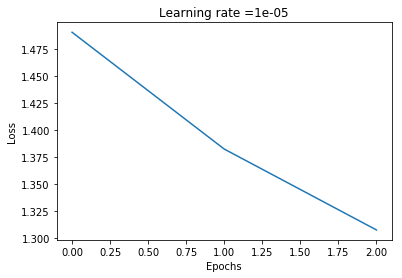

In [96]:
plt.plot(np.squeeze(losses))
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title("Learning rate =" + str(learning_rate))
plt.show()

In [97]:
np.mean((np.argmax(Y_train, 1) == Y_train_preds).astype(int))

0.872191712431353

In [98]:
Y_train_vec = np.argmax(Y_train, 1)

In [99]:
Y_train_vec

array([6, 0, 1, ..., 0, 1, 1])

In [100]:
Y_train_preds

array([2., 0., 1., ..., 0., 1., 1.])

In [101]:
cm = confusion_matrix(Y_train_vec, Y_train_preds)

In [102]:
cm

array([[ 1244,   613,    19,    16,    98,     0,     0],
       [  178, 11704,    55,    17,   112,     0,     0],
       [   28,    53,   797,    22,    25,     0,     0],
       [   27,    29,    41,   436,    62,     0,     0],
       [   99,   304,    24,    18,  1541,     0,     0],
       [   21,    86,    45,    30,    28,     1,     0],
       [   12,   128,    71,     4,    39,     0,     0]])

In [103]:
np.sum(cm, axis = 0)

array([ 1609, 12917,  1052,   543,  1905,     1,     0])

In [104]:
np.diagonal(cm)

array([ 1244, 11704,   797,   436,  1541,     1,     0])

In [105]:
precision = np.diagonal(cm)/np.sum(cm, axis = 0)

In [106]:
precision

array([0.77315103, 0.90609275, 0.75760456, 0.80294659, 0.80892388,
       1.        ,        nan])

In [107]:
np.nanmean(precision)

0.8414531352882063

In [108]:
def get_metrics(actuals, preds):
    accuracy = np.mean((actuals == preds).astype(int))
    cm = confusion_matrix(actuals, preds)
    diag = np.diagonal(cm)
    vert_sum = np.sum(cm, axis = 0)
    hor_sum = np.sum(cm, axis = 1)
    precision = np.nanmean(diag/vert_sum)
    recall = np.nanmean(diag/hor_sum)
    
    metrics = {'accuracy': accuracy,'confusion_matrix': cm, 'precision':precision, 'recall': recall}
    return metrics

In [109]:
train_metrics = get_metrics(Y_train_vec, Y_train_preds)

In [110]:
train_metrics['accuracy']

0.872191712431353

In [111]:
train_metrics['confusion_matrix']

array([[ 1244,   613,    19,    16,    98,     0,     0],
       [  178, 11704,    55,    17,   112,     0,     0],
       [   28,    53,   797,    22,    25,     0,     0],
       [   27,    29,    41,   436,    62,     0,     0],
       [   99,   304,    24,    18,  1541,     0,     0],
       [   21,    86,    45,    30,    28,     1,     0],
       [   12,   128,    71,     4,    39,     0,     0]])

In [112]:
train_metrics['precision']

0.8414531352882063

In [113]:
train_metrics['recall']

0.5671699369418978

In [114]:
Y_dev_vec = np.argmax(Y_dev, axis = 1)

In [115]:
Y_dev_vec

array([1, 1, 1, ..., 1, 1, 1])

In [116]:
dev_metrics = get_metrics(Y_dev_vec, Y_dev_preds)

In [117]:
dev_metrics['accuracy']

0.8287568647029456

In [118]:
dev_metrics['confusion_matrix']

array([[ 128,   79,    5,    5,   19,    0,    0],
       [  32, 1277,   14,    2,   19,    0,    0],
       [   3,   11,   72,    9,    8,    0,    0],
       [   3,    2,    7,   40,    7,    0,    0],
       [  17,   40,    6,    6,  143,    0,    0],
       [   1,    6,    6,    2,    4,    0,    0],
       [   0,   12,   11,    2,    5,    0,    0]])

In [119]:
dev_metrics['precision']

0.6978398901415093

In [120]:
dev_metrics['recall']

0.5062921743821488